In [1]:
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import imblearn
from sklearn.preprocessing import LabelEncoder
import fastai
from fastai import *
import fastai.tabular.all

In [2]:
data_file = '../5v_cleandf.rdata'
r_format = pyreadr.read_r(data_file)

In [3]:
r_format.keys()

odict_keys(['df'])

In [4]:
df = r_format['df']
df.head().T

,0,1,2,3,4
dep_name,B,B,B,A,A
esi,4,4,2,2,3
age,40,66,66,66,84
gender,Male,Male,Male,Male,Female
ethnicity,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino
...,...,...,...,...,...
cc_woundcheck,0,0,0,0,0
cc_woundinfection,0,0,0,0,0
cc_woundre-evaluation,0,0,0,0,0
cc_wristinjury,0,0,0,0,0


In [5]:
for col in df.columns:
    print(col)

dep_name
esi
age
gender
ethnicity
race
lang
religion
maritalstatus
employstatus
insurance_status
disposition
arrivalmode
arrivalmonth
arrivalday
arrivalhour_bin
previousdispo
2ndarymalig
abdomhernia
abdomnlpain
abortcompl
acqfootdef
acrenlfail
acutecvd
acutemi
acutphanm
adjustmentdisorders
adltrespfl
alcoholrelateddisorders
allergy
amniosdx
analrectal
anemia
aneurysm
anxietydisorders
appendicitis
artembolism
asppneumon
asthma
attentiondeficitconductdisruptivebeha
backproblem
biliarydx
birthasphyx
birthtrauma
bladdercncr
blindness
bnignutneo
bonectcncr
bph
brainnscan
breastcancr
breastdx
brnchlngca
bronchitis
burns
cardiaarrst
cardiacanom
carditis
cataract
cervixcancr
chestpain
chfnonhp
chrkidneydisease
coaghemrdx
coloncancer
comabrndmg
complicdevi
complicproc
conduction
contraceptiv
copd
coronathero
crushinjury
cysticfibro
deliriumdementiaamnesticothercognitiv
developmentaldisorders
diabmelnoc
diabmelwcm
disordersusuallydiagnosedininfancych
diverticulos
dizziness
dminpreg
dysrhythmia
e

Potentially relevant columns here are `gender`, `ethnicity`, `race`, `employstatus`, `insurance_status`, `disposition`. The majority of the columns are categorical results of whether a patient has a condition or not.

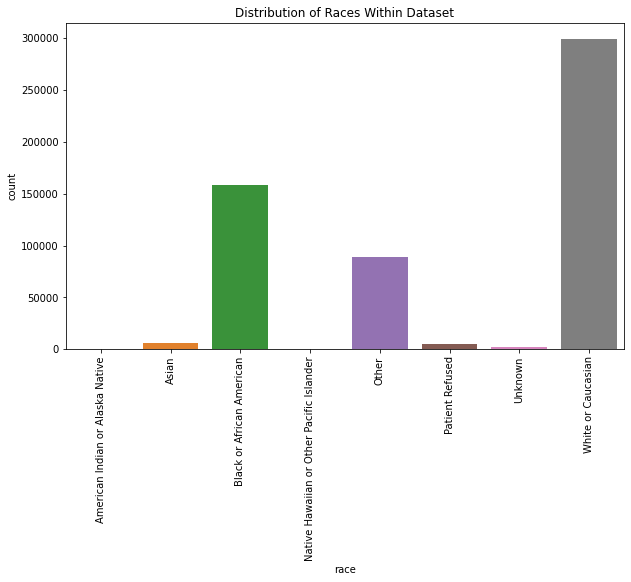

In [6]:
fig = plt.figure(figsize=(10, 6))
sns.countplot(x='race', data=df)
plt.title('Distribution of Races Within Dataset')
plt.xticks(rotation=90)
plt.show()

In [7]:
df['race'].value_counts()

White or Caucasian                           299632
Black or African American                    157884
Other                                         89359
Asian                                          5790
Patient Refused                                5203
Unknown                                        1702
American Indian or Alaska Native                515
Native Hawaiian or Other Pacific Islander       375
Name: race, dtype: int64

# Insurance

In [8]:
def pie_chart(insurance_status, data, data2):
    color_palette = {
        'White or Caucasian': 'blue',
        'Black or African American': 'orange',
        'Other': 'green',
        'Asian': 'red',
        'Patient Refused': 'purple',
        'Unknown': 'brown',
        'American Indian or Alaska Native': 'pink',
        'Native Hawaiian or Other Pacific Islander': 'gray',
        np.nan: 'yellow'
    } # set the color palette so that all plots have the same colors for the same race
    fig = plt.figure(figsize=(15, 15))
    
    def pie_subplot(data, row, col, which, title):
        # get the subsection of the dataframe with that particular insurance status
        data_with_insurance_status = data[data['insurance_status'] == insurance_status]
        unique_races = data_with_insurance_status['race'].unique()

        keys_data = []
        for race in unique_races:
            keys_data.append(
                (
                    race,
                    data_with_insurance_status[data_with_insurance_status['race'] == race]['race']
                        .count()
                ) # append a particular race and the number of people with a particular insurance status
            )

        keys_data.sort(key=lambda x: x[1], reverse=True) # sort by the number of people

        keys = [x[0] for x in keys_data]
        values = [x[1] for x in keys_data]

        colors = [color_palette[x] for x in keys]

        # Plot a pie chart
        plt.subplot(row, col, which)
        plt.pie(values, colors=colors)
        plt.legend(keys)
        plt.title(title)

    # data is a comprised of samples of 100 datapoints for each race because there aren't an
    # equal amount of each race --> this is a way to show the real distribution
    pie_subplot(data, 1, 2, 1, insurance_status)
    # data2 is just the whole dataframe
    pie_subplot(data2, 1, 2, 2, insurance_status + " Real")
    
    plt.show()

In [9]:
def create_sampled_df(df):
    sample1 = df[df['race'] == 'White or Caucasian'].sample(n=100)
    sample2 = df[df['race'] == 'Black or African American'].sample(n=100)
    sample3 = df[df['race'] == 'Other'].sample(n=100)
    sample4 = df[df['race'] == 'Asian'].sample(n=100)
    sample5 = df[df['race'] == 'Patient Refused'].sample(n=100)
    sample6 = df[df['race'] == 'Unknown'].sample(n=100)
    sample7 = df[df['race'] == 'American Indian or Alaska Native'].sample(n=100)
    sample8 = df[df['race'] == 'Native Hawaiian or Other Pacific Islander'].sample(n=100)

    # Put the samples together into one dataframe for use
    plot_df = pd.concat([sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8])
    return plot_df

In [10]:
plot_df = create_sampled_df(df)

## Visualizing Race Distributions of Insurance Types

In [11]:
print(list(df['insurance_status'].unique()))

['Other', 'Commercial', 'Medicare', 'Medicaid', 'Self pay']


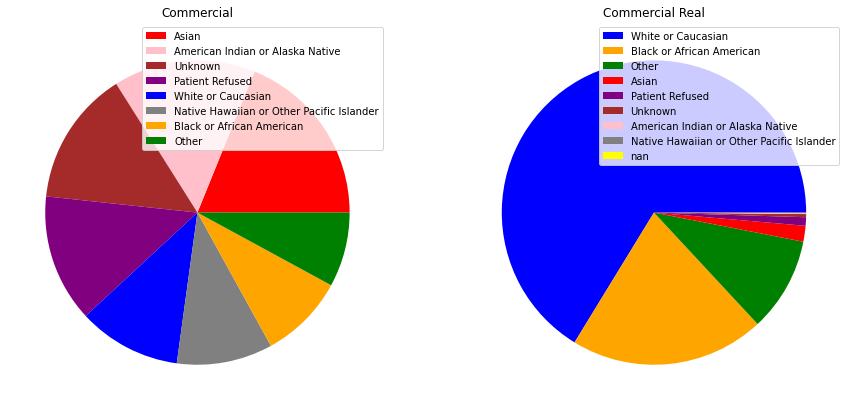

In [12]:
pie_chart('Commercial', plot_df, df)

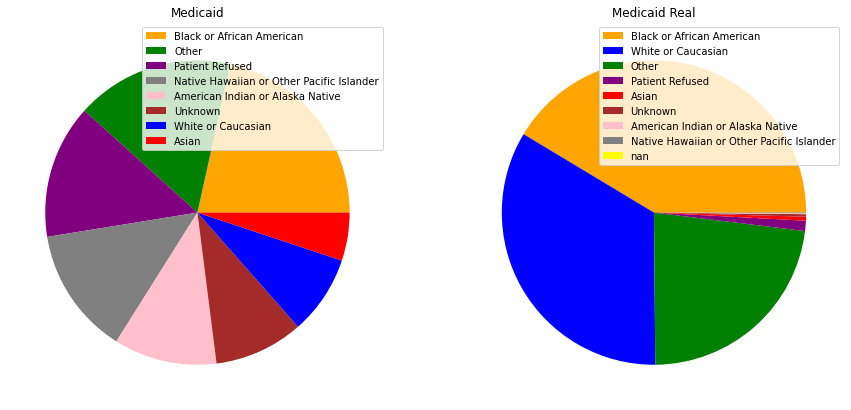

In [13]:
pie_chart('Medicaid', plot_df, df)

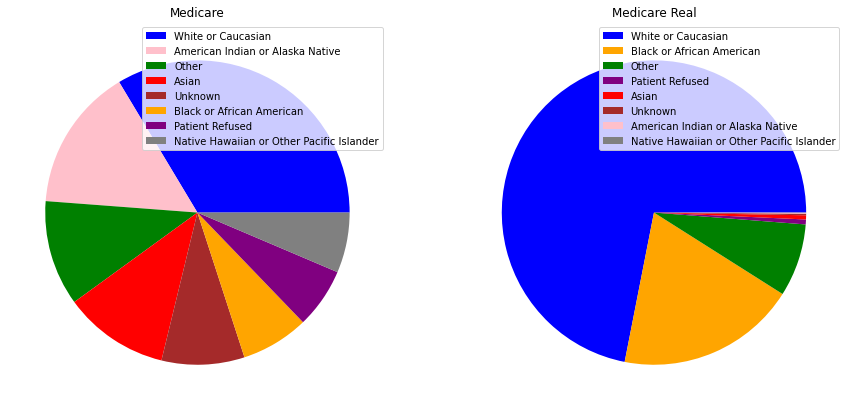

In [14]:
pie_chart('Medicare', plot_df, df)

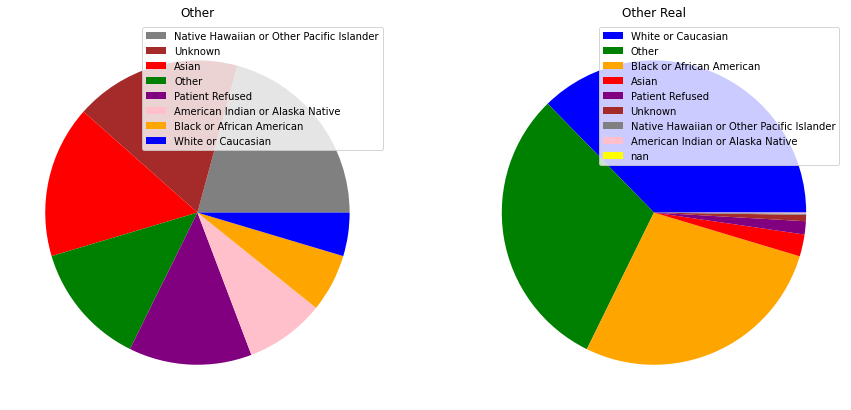

In [15]:
pie_chart('Other', plot_df, df)

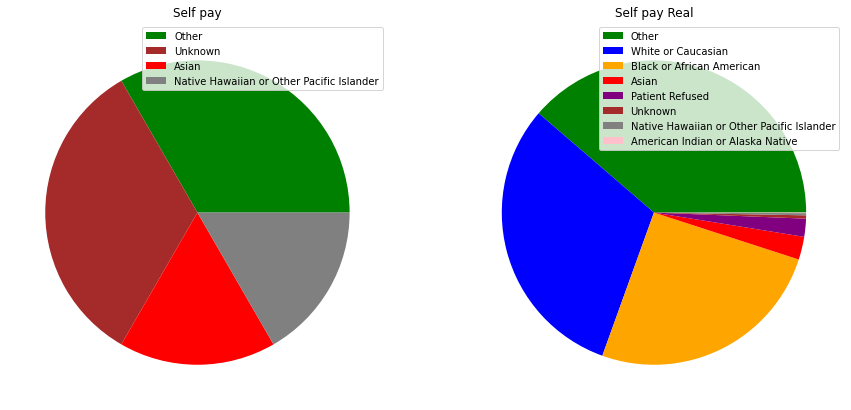

In [16]:
pie_chart('Self pay', plot_df, df)

The only notable thing I noticed was that despite its smaller population, a greater percentage of black people have Medicaid.

# Employment Status

In [17]:
print(list(df['employstatus'].unique()))

['Full Time', 'Not Employed', 'Retired', 'Disabled', 'Part Time', 'Self Employed', 'On Active Military Duty', 'Student - Full Time', 'Unknown', 'Student - Part Time']


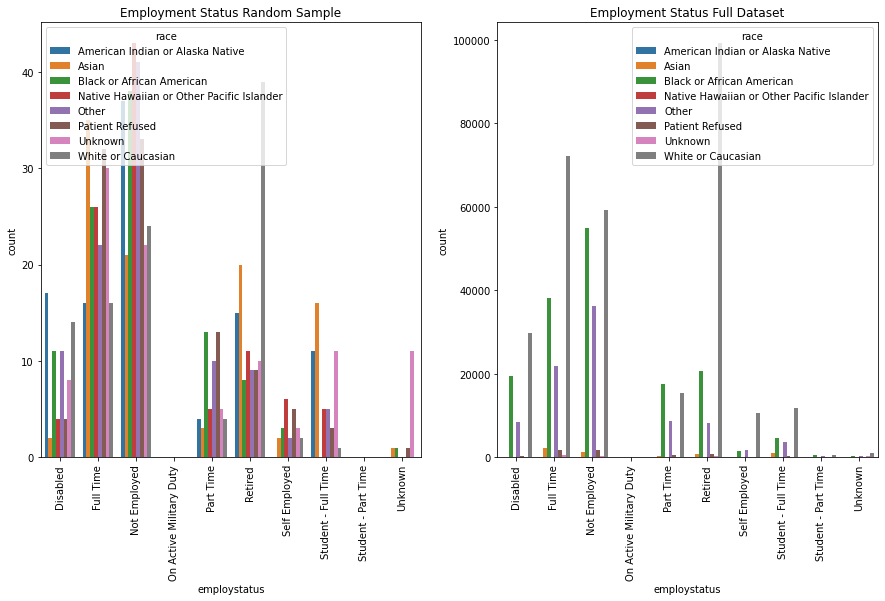

In [18]:
fig = plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.countplot(x='employstatus', data=plot_df, hue='race')
plt.xticks(rotation=90)
plt.title('Employment Status Random Sample')
plt.subplot(1, 2, 2)
sns.countplot(x='employstatus', data=df, hue='race')
plt.xticks(rotation=90)
plt.title('Employment Status Full Dataset')
plt.show()

There are no blatant disparrities within the employment status.

# Disposition

In [19]:
print(list(df['disposition'].unique()))

['Discharge', 'Admit']


In [20]:
print(list(df['previousdispo'].unique()))

['No previous dispo', 'Discharge', 'Admit', 'Transfer to Another Facility', 'AMA', 'LWBS after Triage', 'Eloped', 'LWBS before Triage', 'Observation', 'Send to L&D']


## Heatmap of Race & Disposition on Full Dataframe

In [21]:
def p(contingency):
    c, p_val, dof, expected = chi2_contingency(contingency)
    return p_val

In [22]:
contingency = pd.crosstab(df['race'], df['previousdispo'])
contingency

previousdispo,AMA,Admit,Discharge,Eloped,LWBS after Triage,LWBS before Triage,No previous dispo,Observation,Send to L&D,Transfer to Another Facility
race,,,,,,,,,,
American Indian or Alaska Native,1,106,243,3,6,2,145,0,1,8
Asian,11,644,1805,2,28,0,3089,0,1,210
Black or African American,870,30079,90887,668,2134,405,31153,97,91,1500
Native Hawaiian or Other Pacific Islander,0,40,166,1,5,1,156,0,0,6
Other,372,13351,48078,283,1055,135,25344,49,63,629
Patient Refused,14,678,2395,7,37,10,2014,0,4,44
Unknown,8,170,580,2,11,3,911,0,0,17
White or Caucasian,1252,72808,118076,586,1495,241,101186,180,48,3760


In [23]:
# contingency_pct = pd.crosstab(df['race'], df['previousdispo'], normalize='index')
# contingency_pct

<AxesSubplot:xlabel='previousdispo', ylabel='race'>

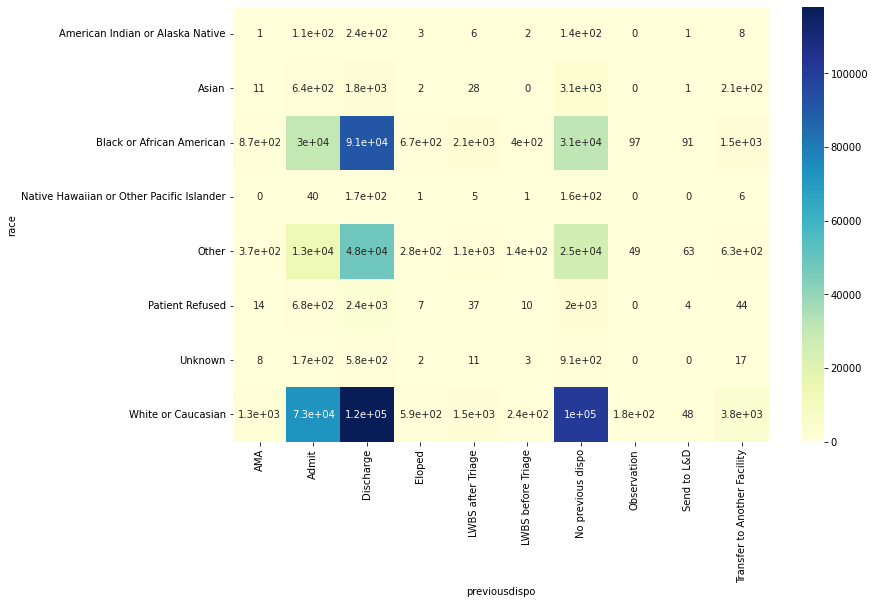

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(contingency, annot=True, cmap='YlGnBu')

* L&D -> Labor And Delivey
* LWBS -> Left Without Being Seen By Physician
* AMA -> Against Medical Service ??
* Eloped -> Eloped During Treatment

In [25]:
p(contingency)
#surface level stat analysis shows a correlation btw ethnicity and disposition within the hospital

0.0

## Heatmap of Race & Disposition on Sampled Dataframe

In [26]:
contingency = pd.crosstab(plot_df['race'], plot_df['previousdispo'])
contingency

previousdispo,Admit,Discharge,Eloped,LWBS after Triage,LWBS before Triage,No previous dispo,Observation,Transfer to Another Facility
race,,,,,,,,
American Indian or Alaska Native,14,51,1,1,0,30,0,3
Asian,14,28,0,0,0,56,0,2
Black or African American,20,57,0,1,1,18,1,2
Native Hawaiian or Other Pacific Islander,11,47,0,1,0,39,0,2
Other,14,52,0,1,0,31,0,2
Patient Refused,13,50,0,0,0,36,0,1
Unknown,9,28,0,0,0,61,0,2
White or Caucasian,24,47,0,0,0,27,0,2


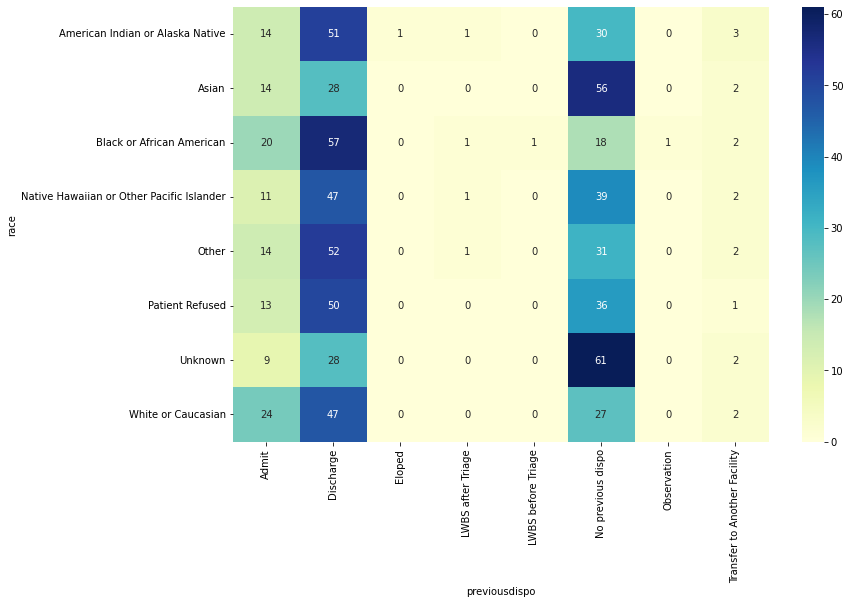

In [27]:
plt.figure(figsize=(12, 8))
sns.heatmap(contingency, annot=True, cmap="YlGnBu")
plt.show()

In [28]:
p(contingency)
#surface level stat analysis shows a correlation btw ethnicity and disposition within the hospital

7.522336383194613e-05

## Heatmap of Gender & Disposition

<AxesSubplot:xlabel='previousdispo', ylabel='gender'>

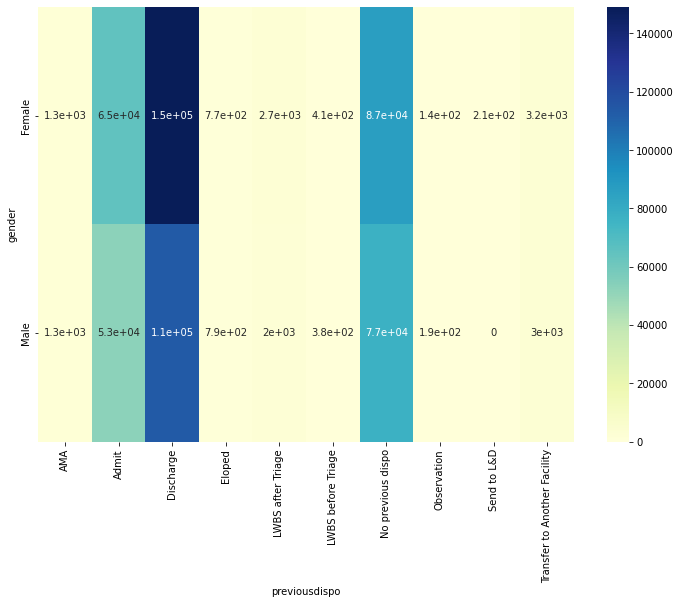

In [29]:
contingency = pd.crosstab(df['gender'], df['previousdispo'])
plt.figure(figsize=(12, 8))
sns.heatmap(contingency, annot=True, cmap="YlGnBu")

In [30]:
p(contingency)

5.440742225607243e-192

## Heatmap of Age & Disposition

In [31]:
(df.age.max(), df.age.min())

(108, 18)

In [32]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ['(0-10]', '(10-20]', '(20-30]', '(30-40]',
          '(40-50]', '(50-60]', '(60-70]', '(70-80]', '(80-90]', '(90-100]', '(100-110]']

df['age_groups'] = pd.cut(x=df['age'], bins=bins, labels=labels)
df['age_groups']

0         (30-40]
1         (60-70]
2         (60-70]
3         (60-70]
4         (80-90]
           ...   
560481    (40-50]
560482    (40-50]
560483    (40-50]
560484    (40-50]
560485    (40-50]
Name: age_groups, Length: 560486, dtype: category
Categories (11, object): ['(0-10]' < '(10-20]' < '(20-30]' < '(30-40]' ... '(70-80]' < '(80-90]' < '(90-100]' < '(100-110]']

<AxesSubplot:xlabel='previousdispo', ylabel='age_groups'>

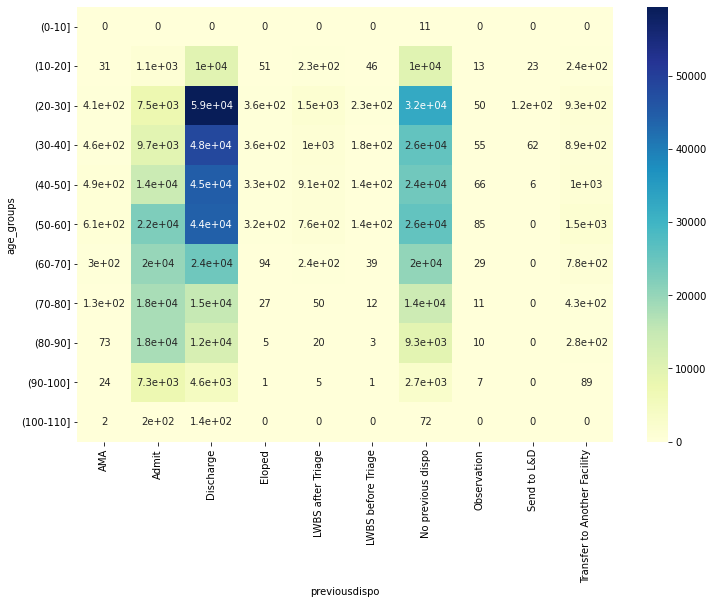

In [33]:
contingency = pd.crosstab(df['age_groups'], df['previousdispo'])
plt.figure(figsize=(12, 8))
sns.heatmap(contingency, annot=True, cmap="YlGnBu")

In [34]:
p(contingency)

0.0

## Heatmap of Race & Arrival Mode

<AxesSubplot:xlabel='arrivalmode', ylabel='race'>

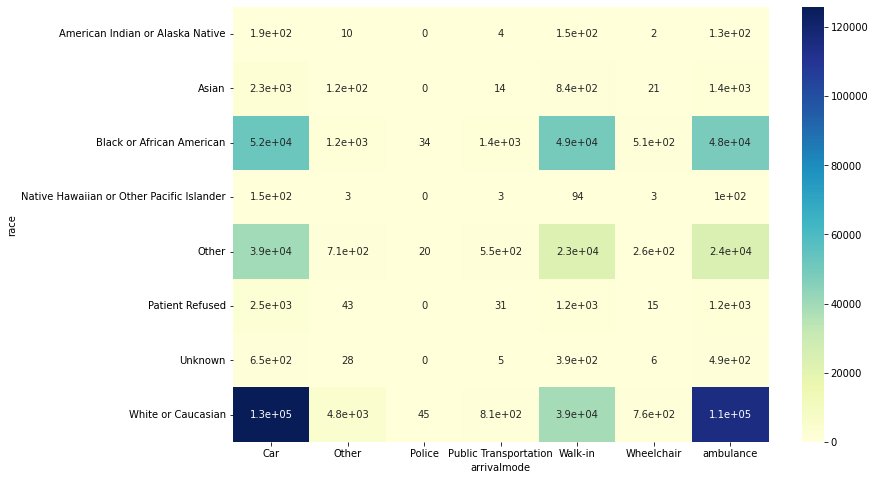

In [35]:
contingency = pd.crosstab(df['race'], df['arrivalmode'])
plt.figure(figsize=(12, 8))
sns.heatmap(contingency, annot=True, cmap="YlGnBu")

In [36]:
p(contingency)

0.0

# Condensing Dataset

Condense the large dataframe into another with only the necessary columns.

The columns of the dataframe have a significant member of **null** values; however, we still have enough data, that removing the rows with any null values will leave us with plenty of data. Therefore, instead of letting the nulls propogate to more refined versions of the dataset, we can remove them right here.

First we create a smaller dataframe with only the columns we care about, in order to condense the data and speed up operation times.

In [37]:
columns = ['esi',
           'age',
           'gender',
           'ethnicity',
           'race',
           'lang',
           'religion',
           'maritalstatus',
           'employstatus',
           'insurance_status',
           'disposition',
           'arrivalmode',
           'previousdispo']

data = df.copy()[columns]

In [38]:
data.shape

(560486, 13)

In [39]:
# Remove the rows with missing values for every column

cols_in_dataframe = list(data.columns)

for col in cols_in_dataframe:
    rows_to_remove = []
    nulled_col = list(data[col].isnull())
    for i in range(len(nulled_col)):
        if nulled_col[i] == True:
            rows_to_remove.append(i)
    rows_to_remove.sort(reverse=True)
    
    data.drop(rows_to_remove, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    print('Done condensing:', col)

Done condensing: esi
Done condensing: age
Done condensing: gender
Done condensing: ethnicity
Done condensing: race
Done condensing: lang
Done condensing: religion
Done condensing: maritalstatus
Done condensing: employstatus
Done condensing: insurance_status
Done condensing: disposition
Done condensing: arrivalmode
Done condensing: previousdispo


In [40]:
data.shape

(537194, 13)

All the rows with a **null** value in them are now removed from the dataframe.

# Creating An Averaged Table

In [41]:
# ( number of samples, contingency variable 1, contingency variable 2, dataframe )
def create_samples(num_samples, contv1, contv2, df):
    samples = []
    for i in range(num_samples):
        plot_df = create_sampled_df(df)
        contingency = pd.crosstab(plot_df[contv1], plot_df[contv2])

        # find the columns that were not in the contingency table
        # all the columns that are left over
        left_over = list(set(df[contv2].unique()) - set(contingency.columns))
        for col in left_over:
            contingency[col] = [0 for _ in list(contingency.index)]

        samples.append(contingency)
    return samples


def create_average_contingency_table(samples):
    samples_len = len(samples)
    main_df = pd.DataFrame()

    shapes = [x.shape for x in samples]
    example_sample = samples[0]

    for col in example_sample:
        values = []
        for sample in samples:
            values.append(np.array(sample[col]))
        values = np.array(values)
        average_values = np.mean(values, axis=0)
        main_df[col] = average_values

    main_df = main_df.set_index(pd.Index(example_sample.index))
    return main_df

In [42]:
samples = create_samples(100, 'race', 'previousdispo', data)

In [43]:
average_cont_table = create_average_contingency_table(samples)
average_cont_table

,AMA,Admit,Discharge,Eloped,LWBS after Triage,LWBS before Triage,No previous dispo,Send to L&D,Transfer to Another Facility,Observation
race,,,,,,,,,,
American Indian or Alaska Native,0.16,21.45,46.83,0.62,1.27,0.40,27.58,0.21,1.48,0.00
Asian,0.12,13.14,26.62,0.01,0.54,0.00,55.31,0.04,4.22,0.00
Black or African American,0.66,19.68,57.56,0.47,1.22,0.32,19.16,0.05,0.79,0.09
Native Hawaiian or Other Pacific Islander,0.00,11.27,43.01,0.34,1.60,0.31,41.77,0.00,1.70,0.00
Other,0.36,15.14,53.97,0.30,1.05,0.13,28.26,0.13,0.62,0.04
Patient Refused,0.28,14.02,45.27,0.14,0.69,0.18,38.54,0.03,0.85,0.00
Unknown,0.41,10.40,33.82,0.03,0.60,0.17,53.49,0.00,1.08,0.00
White or Caucasian,0.39,24.79,37.68,0.18,0.44,0.08,35.17,0.04,1.19,0.04


# Modifying Dataframe

In [44]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(sampling_strategy='minority')

In [45]:
%%capture
cont = ['esi', 'age']
cat = [
    'gender',
    'ethnicity',
    'race',
    'lang',
    'religion',
    'maritalstatus',
    'employstatus',
    'insurance_status',
    'disposition',
    'arrivalmode',
    'previousdispo'
]

# Create individual label encoders for each column
transformers = {}
for col in cat:
    transformers[col] = LabelEncoder()

# fit each column with its corresponding label encoder
for col in cat:
    data[col] = data[[col]].apply(transformers[col].fit_transform)

In [46]:
data.head(2)

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,previousdispo
0,4,40,1,0,7,0,8,7,1,3,1,4,6
1,4,66,1,0,3,0,10,4,2,0,1,0,6


The `esi` column is stored as a string, but it is more convenient to convert it to a number.

In [47]:
data['esi'] = data['esi'].astype(int)

It is better to split the training and the testing set at this point, so as not to ruin the accuracy checking.

In [48]:
procedures = []
splits = fastai.tabular.all.RandomSplitter(
    valid_pct=0.2, seed=42)(fastai.tabular.all.range_of(data))

cont = ['esi', 'age']
cat = [
    'gender',
    'ethnicity',
    'race',
    'lang',
    'religion',
    'maritalstatus',
    'employstatus',
    'insurance_status',
    'disposition',
    'arrivalmode',
]

`cat` and `cont` are the *categorical* and the *continuous* variables.

`esi` can technically be categorized as a *categorical* variable as well. However, the numbers show a varying degree of intensity, so we can keep it as a continuous variable.

In [49]:
to = fastai.tabular.all.TabularPandas(
    df=data,
    procs=procedures,
    cat_names=cat,
    cont_names=cont,
    y_names='previousdispo',
    splits=splits
)
to.show(5)

,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,esi,age,previousdispo
362078,0,1,7,0,1,7,2,1,1,6,2,48,1
233140,1,1,7,0,8,4,2,1,1,6,2,49,1
125659,0,1,7,0,8,4,5,2,0,6,3,80,1
122418,0,1,2,0,10,7,1,0,1,0,3,34,2
40344,0,1,7,0,2,4,1,0,1,0,4,36,6


In [50]:
X_train, y_train = to.train.xs, to.train.y
X_test, y_test = to.valid.xs, to.valid.y

This operation leaves us with two split datasets. `X_train` and `y_train` is as dataset that contains **80%** of the original dataset, and `X_test` and `y_test` contains **20%** of the original dataset. `X_train` contains all the columns of the original dataset, except the dependent variable, which is `previous_dispo`, which is what `y_train` contains.

In [51]:
X_train.columns

Index(['gender', 'ethnicity', 'race', 'lang', 'religion', 'maritalstatus',
       'employstatus', 'insurance_status', 'disposition', 'arrivalmode', 'esi',
       'age'],
      dtype='object')

In [52]:
# consolidate X back into a normal pandas dataframe
X_train = pd.DataFrame(X_train.values, columns=list(X_train.columns))

In [53]:
X_train.head()

,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,esi,age
0,0,1,7,0,1,7,2,1,1,6,2,48
1,1,1,7,0,8,4,2,1,1,6,2,49
2,0,1,7,0,8,4,5,2,0,6,3,80
3,0,1,2,0,10,7,1,0,1,0,3,34
4,0,1,7,0,2,4,1,0,1,0,4,36


In [54]:
X_train['previousdispo'] = y_train.values

In [55]:
X_train.head()

,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,esi,age,previousdispo
0,0,1,7,0,1,7,2,1,1,6,2,48,1
1,1,1,7,0,8,4,2,1,1,6,2,49,1
2,0,1,7,0,8,4,5,2,0,6,3,80,1
3,0,1,2,0,10,7,1,0,1,0,3,34,2
4,0,1,7,0,2,4,1,0,1,0,4,36,6


Now, since the training dataset and the testing dataset are split, we can oversample the minority in the training dataset.

In [56]:
col_to_balance = 'race'
cols_without_balancing_col = [
    'esi',
    'age',
    'gender',
    'ethnicity',
    'lang',
    'religion',
    'maritalstatus',
    'employstatus',
    'insurance_status',
    'disposition',
    'arrivalmode',
    'previousdispo'
]

df_without_race, df_with_race = X_train[cols_without_balancing_col].values, X_train[col_to_balance].values

The resampler resamples the smallest member to the biggest member and this needs to be done a certain number of times to get an equal amount of each race within the dataset.

In [57]:
df_without_race_rebalanced, df_with_race_rebalanced = sampler.fit_resample(df_without_race, df_with_race)
df_without_race_rebalanced, df_with_race_rebalanced = sampler.fit_resample(df_without_race_rebalanced, df_with_race_rebalanced)
df_without_race_rebalanced, df_with_race_rebalanced = sampler.fit_resample(df_without_race_rebalanced, df_with_race_rebalanced)
df_without_race_rebalanced, df_with_race_rebalanced = sampler.fit_resample(df_without_race_rebalanced, df_with_race_rebalanced)
df_without_race_rebalanced, df_with_race_rebalanced = sampler.fit_resample(df_without_race_rebalanced, df_with_race_rebalanced)
df_without_race_rebalanced, df_with_race_rebalanced = sampler.fit_resample(df_without_race_rebalanced, df_with_race_rebalanced)
df_without_race_rebalanced, df_with_race_rebalanced = sampler.fit_resample(df_without_race_rebalanced, df_with_race_rebalanced)
df_without_race_rebalanced, df_with_race_rebalanced = sampler.fit_resample(df_without_race_rebalanced, df_with_race_rebalanced)
df_without_race_rebalanced, df_with_race_rebalanced = sampler.fit_resample(df_without_race_rebalanced, df_with_race_rebalanced)

Some of the races are extremely small in propertion to other races. The operation above scales all the data from the races with the smallest dataset population to the races with the largest dataset population. This results in a lot of generated or repeated data, which might affect the quality of the models that this data can produce.

In [58]:
from collections import Counter

In [60]:
Counter(df_with_race_rebalanced)

Counter({7: 228519,
         2: 228519,
         4: 228519,
         5: 228519,
         1: 228519,
         6: 228519,
         0: 228519,
         3: 228519})

Above is now the number of samples for each race where the numbers `[0-7]` can be corresponded to a label encoded race. The race can be derived with `transformers['race'].inverse_transform([0, 1, 2, 3, 4, 5, 7, 7])`.

In [61]:
df_without_race_rebalanced.shape

(1828152, 12)

In [62]:
full_dataframe_rebalanced = pd.DataFrame(df_without_race_rebalanced, columns=cols_without_balancing_col)

In [63]:
full_dataframe_rebalanced.head()

,esi,age,gender,ethnicity,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,previousdispo
0,2,48,0,1,0,1,7,2,1,1,6,1
1,2,49,1,1,0,8,4,2,1,1,6,1
2,3,80,0,1,0,8,4,5,2,0,6,1
3,3,34,0,1,0,10,7,1,0,1,0,2
4,4,36,0,1,0,2,4,1,0,1,0,6


In [65]:
full_dataframe_rebalanced['previousdispo'] = df_with_race_rebalanced

In [66]:
full_dataframe_rebalanced.head()

,esi,age,gender,ethnicity,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,previousdispo
0,2,48,0,1,0,1,7,2,1,1,6,7
1,2,49,1,1,0,8,4,2,1,1,6,7
2,3,80,0,1,0,8,4,5,2,0,6,7
3,3,34,0,1,0,10,7,1,0,1,0,2
4,4,36,0,1,0,2,4,1,0,1,0,7


In [68]:
training_cols = ['esi', 'age', 'gender', 'ethnicity', 'lang', 'religion',
       'maritalstatus', 'employstatus', 'insurance_status', 'disposition',
       'arrivalmode']
dep_var_col = 'previousdispo'

In [69]:
X_train = full_dataframe_rebalanced[training_cols]

In [70]:
y_train = full_dataframe_rebalanced[dep_var_col]

In [71]:
X_train.shape, y_train.shape

((1828152, 11), (1828152,))

In [76]:
X_test = X_test[training_cols]

# Random Forest (300)

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
model = RandomForestClassifier(300, verbose=2, n_jobs=-1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 300building tree 2 of 300

building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.8s


building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.8min


building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.6min finished


RandomForestClassifier(n_estimators=300, n_jobs=-1, verbose=2)

In [78]:
preds = model.predict(X_test)
preds

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    3.5s finished


array([7, 7, 2, ..., 2, 1, 4], dtype=int64)

In [80]:
from sklearn.metrics import f1_score
f1_score(y_test, preds, average = None)

array([0.00548697, 0.02827881, 0.43482068, 0.        , 0.02220157,
       0.00180832, 0.01667241, 0.00126853, 0.        , 0.        ])

NameError: name 'full' is not defined

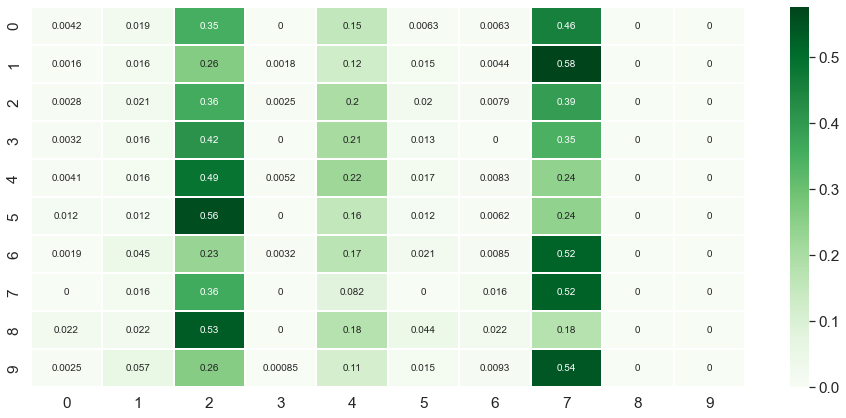

In [81]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

plot_labels = list(full['previousdispo'].unique())
plot_labels.sort()
plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Decision Tree

It has a hard time predicting `LWBS before Triage` and `Observation`.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
model = tree.DecisionTreeClassifier(max_depth= 5000)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [ ]:
f1_score(y_test, preds, average = None)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

plot_labels = list(full['previousdispo'].unique())
plot_labels.sort()
plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()

# Random Forest (500)

It has a hard time predicting `LWBS before Triage` and `Observation`.

In [ ]:
model = RandomForestClassifier(500, verbose=2, n_jobs=-1)
model.fit(X_train, y_train)

In [ ]:
preds = model.predict(X_test)
preds

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, preds, average = None)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

plot_labels = list(full['previousdispo'].unique())
plot_labels.sort()
plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Random Forest (800)

The results are less than encouraging.

In [ ]:
X_train.shape

Divisors of `1827162` are `1, 2, 3, 6, 9, 18, 83, 166, 249, 498, 747, 1223, 1494, 2446, 3669, 7338, 11007, 22014, 101509, 203018, 304527, 609054, 913581, 1827162`. [Divisors Calculator](https://www.hackmath.net/en/calculator/divisors?n=1827162&submit=Calculate)

In [ ]:
batch_size = 1494

X_train_batches = [X_train[x : x + batch_size] for x in range(0, len(X_train), batch_size)]
y_train_batches = [y_train[x : x + batch_size] for x in range(0, len(y_train), batch_size)]

X_train_batches = np.array(X_train_batches)
y_train_batches = np.array(y_train_batches)

In [ ]:
X_train_batches.shape, y_train_batches.shape

In [ ]:
model = RandomForestClassifier(800, n_jobs=-1)
batched_data = list(zip(X_train_batches, y_train_batches))

counter = 1
for i, j in batched_data:
    model.fit(i, j)
    print(f'Done with batch {counter} of {len(batched_data)}')
    counter += 1

In [ ]:
preds = model.predict(X_test)
preds

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, preds, average = None)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

plot_labels = list(full['previousdispo'].unique())
plot_labels.sort()
plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Conclusions

A potential problem with the current state of this notebook is that the validation data is also repeated, or generated by the oversampling algorithm, which might be a problem for determining the accuracy.  

In addition, many of the models have a hard time predicting `LWBS before Triage` and `Observation`.

#### Agenda
1. Use other machine learning techniques
2. Find other way to balance the data that won't lead to lots of repeated data.
Last Priority:
3. Attempt incorporating Shap Values so we can see the specific datapoints that influence disposition of patient the most
4. Attempt incorporating PCA - dimensionality-reducing model to identify important columns

# Neural Network for Classification using Tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
tf.random.set_seed(42)

In [ ]:
class_model = tf.keras.Sequential([tf.keras.layers.Dense(1)])

In [ ]:
class_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.SGD(), metrics = ['accuracy'])
class_model.fit(X_train, y_train, epochs = 10000)